# Assignment 1: Bayesian Linear Regression
STATS305C, Stanford University, Spring 2022

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/slinderman/stats305c/blob/master/assignments/hw1/hw1.ipynb)


**Isaac Kleisle-Murphy**

**Collaborators:** Saskia C.

---

In [1]:
# Setup
import torch
from torch.distributions import Normal, Gamma, \
    TransformedDistribution, MultivariateNormal
from torch.distributions.transforms import PowerTransform

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")

## Bayesian Linear Regression

STATS 305A was all about linear regression. In this assignment, you'll revisit that classic model from a Bayesian perspective.

Let $\{\mathbf{x}_n, y_n\}_{n=1}^N$ denote a dataset with covariates $\mathbf{x}_n \in \mathbb{R}^D$ and scalar outcomes $y_n \in \mathbb{R}$. Let $\mathbf{X} \in \mathbb{R}^{N \times D}$ denote the design matrix where each row is a vector of covariates and $\mathbf{y} \in \mathbb{R}^N$ denote the vector of outcomes.

We will model the outcomes as conditionally independent Gaussian random variables given the covariates and the parameters,
\begin{align}
p(\mathbf{y} \mid \mathbf{w}, \sigma^2, \mathbf{X})
&= \prod_{n=1}^N \mathcal{N}(y_n \mid \mathbf{w}^\top \mathbf{x}_n, \sigma^2),
\end{align}
where $\mathbf{w} \in \mathbb{R}^D$ are the _weights_ and $\sigma^2 \in \mathbb{R}_+$ is the conditional variance. 

In a _Bayesian_ linear regression, we place a prior on the parameters,
\begin{align}
p(\mathbf{w}, \sigma^2) &=
\chi^{-2}(\sigma^2 \mid \nu_0, \sigma_0^2) \,
\mathcal{N}(\mathbf{w} \mid \boldsymbol{\mu}_0, \sigma^2 \boldsymbol{\Lambda}_0^{-1}),
\end{align}
where $\nu_0 \in \mathbb{R}_+$ sets the degrees of freedom, $\sigma_0^2$ is the prior mean of the variance parameter, $\boldsymbol{\mu}_0$ is the prior mean of the weights, and $\boldsymbol{\Lambda}_0 \in \mathcal{S}_D$ is a positive definite $D \times D$ precision matrix.

## PyTorch 

As in the notebooks from class, you will use PyTorch to complete the coding portions of this assignment. If you are unfamiliar with PyTorch, [this](https://pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html) webpage provides an introductory tutorial to PyTorch tensors. 

## Problem 1: Derive the Posterior [Math]

Derive the posterior distribution $p(\mathbf{w}, \sigma^2 \mid \mathbf{y}, \mathbf{X}, \boldsymbol{\eta})$ where $\boldsymbol{\eta} = (\nu_0, \sigma_0^2, \boldsymbol{\mu}_0, \boldsymbol{\Lambda}_0)$. It should be of the same form as the prior,

\begin{align}
p(\mathbf{w}, \sigma^2 \mid \mathbf{y}, \mathbf{X}, \boldsymbol{\eta}) 
&= \chi^{-2}(\sigma^2 \mid \nu_N, \sigma_N^2) \mathcal{N}(\mathbf{w} \mid \boldsymbol{\mu}_N, \sigma^2 \boldsymbol{\Lambda}_N^{-1})
\end{align}

for some $\nu_N$, $\sigma_N^2$, $\boldsymbol{\mu}_N$, and $\boldsymbol{\Lambda}_N$. 


---
First, let's simplify the kernel of the Normal-Inverse-Gamma prior, both to save space in the posterior derivation and provide a recognizable form for our (conjugate) posterior. We have:

\begin{align}
p(\mathbf{w}, \sigma^2 |\eta) 
&=
\chi^{-2}(\sigma^2 \mid \nu_0, \sigma_0^2) \,
\mathcal{N}(\mathbf{w} \mid \boldsymbol{\mu}_0, \sigma^2 \boldsymbol{\Lambda}_0^{-1})\\
&=
\Gamma^{-1}\left(\sigma^2 \bigg| \frac{\nu_0}{2}, \frac{\nu_0 \sigma_0^2}{2}
\right)\mathcal{N}(\mathbf{w} \mid \boldsymbol{\mu}_0, \sigma^2 \boldsymbol{\Lambda}_0^{-1}) \\
&
=
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\left[
\frac{
  \left(\frac{\sigma_0^2\nu_0}{2} \right)^{\frac{\nu_0}{2}}
  (\sigma^2)^{-(1 + \frac{\nu_0}{2})}
  \exp\bigg(-\frac{\nu_0\sigma_0^2}{2\sigma^2} \bigg)
}{
  \Gamma(\frac{\nu_0}{2})
}
\right]\\
&\hspace{1cm}\cdot 
\left[
  \frac{1}{(2\pi)^{D/2}}\cdot 
  \frac{1}{|\sigma^2\Lambda_0^{-1}|^{-1/2}}
  \exp\left(
    -\frac{1}{2\sigma^2}(\mathbf{w} - \boldsymbol{\mu}_0)^T\Lambda_0(\mathbf{w} - \boldsymbol{\mu}_0)
  \right)
\right] \\
&\propto 
  (\sigma^2)^{-(1 + \frac{\nu_0}{2})}
  \frac{1}{|\sigma^2\Lambda_0^{-1}|^{-1/2}}
  \exp\bigg(-\frac{\nu_0\sigma_0^2}{2\sigma^2} \bigg)
  \exp\left(
    -\frac{1}{2\sigma^2}\boldsymbol{\mu}_0^T\Lambda_0\boldsymbol{\mu}_0
    -\bigg(\frac{-2}{2\sigma^2}\bigg)\boldsymbol{\mu}_0^T\Lambda_0\mathbf{w}
    -\frac{1}{2\sigma^2}\mathbf{w}^T\Lambda_0\mathbf{w}
  \right)\\
&\propto 
  (\sigma^2)^{-(1 + \frac{\nu_0}{2})}(\sigma^2)^{-D/2}
  \exp\left(
    -\frac{1}{2\sigma^2}(\nu_0\sigma_0^2 + \boldsymbol{\mu}_0^T\Lambda_0\boldsymbol{\mu}_0)
    +\bigg(\frac{1}{\sigma^2}\bigg)\boldsymbol{\mu}_0^T\Lambda_0\mathbf{w}
    -\frac{1}{2\sigma^2}\mathbf{w}^T\Lambda_0\mathbf{w}
  \right)\\
&\propto 
  (\sigma^2)^{-(1 + \frac{\nu_0 + D}{2})}
  \exp\left(
    -\frac{1}{2\sigma^2}(\nu_0\sigma_0^2 + \boldsymbol{\mu}_0^T\Lambda_0\boldsymbol{\mu}_0)
    +\bigg(\frac{1}{\sigma^2}\bigg)\boldsymbol{\mu}_0^T\Lambda_0\mathbf{w}
    -\frac{1}{2\sigma^2}\mathbf{w}^T\Lambda_0\mathbf{w}
  \right)\\
&\propto 
  (\sigma^2)^{-(1 + \frac{\nu_0 + D}{2})}
  \exp\left(
    -\frac{1}{2\sigma^2}(\nu_0\sigma_0^2 + \boldsymbol{\mu}_0^T\Lambda_0\boldsymbol{\mu}_0)
    +\bigg(\frac{1}{\sigma^2}\bigg)\boldsymbol{\mu}_0^T\Lambda_0\mathbf{w}
    -\frac{1}{2\sigma^2}\Lambda_0\mathbf{w}\mathbf{w}^T
  \right).
\end{align}
Steps are justified as follows: (i) definition of Normal-Inverse-Scaled-Chi-Squared; (ii) reparameterization to Normal-Inverse-Gamma; (iii) likelihood functions; (iv) proportionality to relevant variables $\mathbf{w}, \sigma^2$; (v) the fact that $\Lambda_0 \in \mathbb{R}^{D\times D}$, thus meaning $\sigma^2$ shows up $D$ times in the determinant multiplier; (vi) rearrangement; (vii) the fact that $\Lambda_0\succeq 0$ and symmetric, allowing us to rearrange the $\mathbf{w}$ "sandwich" about $\Lambda_0$ (there's gotta be a more professional term for this, no?). 

Now, for the likelihood, we have under likelihood for OLS:
\begin{align}
  \mathcal{L}(\mathbf{y}; \mathbf{X}, \mathbf{w})
  &\propto (\sigma^2)^{-N/2}
  \exp\left( 
  -\frac{1}{2\sigma^2} \mathbf{y}^T\mathbf{y} + \frac{1}{\sigma^2}\mathbf{y}^T\mathbf{X}\mathbf{w} -\frac{1}{2\sigma^2}(\mathbf{X}\mathbf{w})^T(\mathbf{X}\mathbf{w})
  \right) \\
  &=
  \propto (\sigma^2)^{-N/2}
  \exp\left( 
  -\frac{1}{2\sigma^2} \mathbf{y}^T\mathbf{y} + \frac{1}{\sigma^2}\mathbf{y}^T\mathbf{X}\mathbf{w} -\frac{1}{2\sigma^2}\mathbf{w}^T\mathbf{X}^T\mathbf{X}\mathbf{w}
  \right)\\
  &=
  \propto (\sigma^2)^{-N/2}
  \exp\left( 
  -\frac{1}{2\sigma^2} \mathbf{y}^T\mathbf{y} + \frac{1}{\sigma^2}\mathbf{y}^T\mathbf{X}\mathbf{w} -\frac{1}{2\sigma^2}\mathbf{X}^T\mathbf{X}\mathbf{w}\mathbf{w}^T
  \right),
\end{align}
where again $X^TX\succeq 0$ and symmetric, so we may "shuffle" the dot product. 

Now, we multiply the two aforementioned quantities and combine similar terms:
\begin{align}
&\propto\left[
(\sigma^2)^{-(1 + \frac{\nu_0 + D}{2})}
  \exp\left(
    -\frac{1}{2\sigma^2}(\nu_0\sigma_0^2 + \boldsymbol{\mu}_0^T\Lambda_0\boldsymbol{\mu}_0)
    +\bigg(\frac{1}{\sigma^2}\bigg)\boldsymbol{\mu}_0^T\Lambda_0\mathbf{w}
    -\frac{1}{2\sigma^2}\Lambda_0\mathbf{w}\mathbf{w}^T
  \right)
\right]\\
&\hspace{1cm}
\cdot 
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\left[
(\sigma^2)^{-N/2}
  \exp\left( 
  -\frac{1}{2\sigma^2} \mathbf{y}^T\mathbf{y} + \frac{1}{\sigma^2}\mathbf{y}^T\mathbf{X}\mathbf{w} -\frac{1}{2\sigma^2}\mathbf{X}^T\mathbf{X}\mathbf{w}\mathbf{w}^T
  \right)
\right] \\
&=
\left[
(\sigma^2)^{-(1 + \frac{\nu_0 + N}{2}+ \frac{D}{2})}
  \exp\left(
    -\frac{1}{2\sigma^2}(\nu_0\sigma_0^2 + \boldsymbol{\mu}_0^T\Lambda_0\boldsymbol{\mu}_0 + \mathbf{y}^T\mathbf{y})
    +\bigg(\frac{1}{\sigma^2}\bigg)(\boldsymbol{\mu}_0^T\Lambda_0 + \mathbf{y}^T\mathbf{X})\mathbf{w}
    -\frac{1}{2\sigma^2}(\Lambda_0 + \mathbf{X}^T\mathbf{X})\mathbf{w}\mathbf{w}^T
  \right)
\right]
\end{align}
This kernel looks familiar -- in fact, it's the kernel we derived in the prior! That is, it is of the form
\begin{align}
\left[
(\sigma^2)^{-(1 + \frac{\nu_N + D}{2})}
  \exp\left(
    -\frac{1}{2\sigma^2}(\nu_N\sigma_N^2 + \boldsymbol{\mu}_N^T\Lambda_N\boldsymbol{\mu}_N)
    +\bigg(\frac{1}{\sigma^2}\bigg)(\boldsymbol{\mu}_N^T\Lambda_N)\mathbf{w}
    -\frac{1}{2\sigma^2}(\Lambda_N)\mathbf{w}\mathbf{w}^T
  \right)
\right]
\end{align};
we just need to solve a few equations. Off the bat, we can immediately get
- $\Lambda_N = \Lambda_0 + \mathbf{X}^T\mathbf{X}$

- $\nu_n = \nu_0 + N$

Note that since we know $\Lambda_0 \succeq 0$ and clearly $X^TX\succeq 0$, we have a sum of PSD matrices and hence $\Lambda_N \succeq 0$. We must then select $\boldsymbol{\mu}_N$ that satisfies
$$
\boldsymbol{\mu}_N^T\Lambda_N = \boldsymbol{\mu}_0\Lambda_0 + \mathbf{y}^T\mathbf{X}
$$
which upon rearrangement and substitution gives
\begin{align}
\boldsymbol{\mu}_N^T\Lambda_N &= \boldsymbol{\mu}_0^T\Lambda_0 + \mathbf{y}^T\mathbf{X} \\
\boldsymbol{\mu}_N^T &= (\boldsymbol{\mu}_0^T\Lambda_0 + \mathbf{y}^T\mathbf{X})\Lambda_N^{-1}\\
\boldsymbol{\mu}_N &= \Lambda_N^{-1}(\Lambda_0\boldsymbol{\mu}_0 + \mathbf{X}^T\mathbf{y})\\
\boldsymbol{\mu}_N &= (\Lambda_0 + \mathbf{X}^T\mathbf{X})^{-1}(\Lambda_0\boldsymbol{\mu}_0 + \mathbf{X}^T\mathbf{y}).
\end{align}
Justifications are: (i) equation to solve; (ii) $\Lambda_N \succeq 0$ and hence invertible; (iii) transposition and $\Lambda_N$ symmetric; and (iv) substitution of an above quantity. 


Then, finally, we seek $\sigma_N^2$ that satisfies
$$
\nu_N \sigma_N^2 + \boldsymbol{\mu}_N^T\Lambda_N\boldsymbol{\mu}_N
=
\nu_0 \sigma_0^2 + \boldsymbol{\mu}_0^T\Lambda_0\boldsymbol{\mu}_0 + 
\mathbf{y}^T\mathbf{y}.
$$
Hence, we solve
\begin{align}
\sigma_N^2 
& =
\frac{1}{\nu_N}\left(\nu_0 \sigma_0^2 + \boldsymbol{\mu}_0^T\Lambda_0\boldsymbol{\mu}_0 + 
\mathbf{y}^T\mathbf{y} - \boldsymbol{\mu}_N^T\Lambda_N\boldsymbol{\mu}_N
\right) \\
& =
\frac{1}{\nu_0 + N}\left(\nu_0 \sigma_0^2 + \boldsymbol{\mu}_0^T\Lambda_0\boldsymbol{\mu}_0 + 
\mathbf{y}^T\mathbf{y} - \boldsymbol{\mu}_N^T\Lambda_N\boldsymbol{\mu}_N
\right),
\end{align}
where for brevity, the previously found values of $\mathbf{\mu}_N, \Lambda_N$ can be substituted in.

## Problem 2: The Posterior Mean [Math]
a. What does the posterior mean $\mathbb{E}[\mathbf{w} \mid \mathbf{y}, \mathbf{X}, \boldsymbol{\eta}]$ equal in the uninformative limit where $\boldsymbol{\Lambda}_0 \to 0$ and $\nu_0 \to 0$?

b. What does the posterior mean $\mathbb{E}[\sigma^2 \mid \mathbf{y}, \mathbf{X}, \boldsymbol{\eta}]$ equal in the uninformative limit where $\boldsymbol{\Lambda}_0 \to 0$ and $\nu_0 \to 0$? Write your answer in terms of the _hat matrix_ $\mathbf{H} = \mathbf{X} (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top$. 

---

### a.)
As set forth above, the mean of our posterior Normal-Inverse-Gamma is given by 
$$
\mathbb{E}[\mathbf{w} \mid \mathbf{y}, \mathbf{X}, \boldsymbol{\eta}] =\boldsymbol{\mu}_N = (\Lambda_0 + \mathbf{X}^T\mathbf{X})^{-1}(\boldsymbol{\mu}_0\Lambda_0 + \mathbf{X}^T\mathbf{y}).
$$
So when $\Lambda_0 \to 0$, we get 
$$
\boldsymbol{\mu}_N \to
(0 + \mathbf{X}^T\mathbf{X})^{-1}(0 + \mathbf{X}^T\mathbf{y})
=
(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y} = \mathbf{w}_{MLE},
$$
i.e. the MLE OLS estimate with which we're all familiar.

### b.)
Then, when $\nu_0\to 0$ as well, we have 

- $\Lambda_N \to 0 + \mathbf{X}^T\mathbf{X}$

- $\boldsymbol{\mu}_N \to (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$

- $\nu_N \to 0 + N$

and lastly, using all of the above,

\begin{align}
\sigma_N^2 &= 
\frac{1}{\nu_N}\left(\nu_0 \sigma_0^2 + \boldsymbol{\mu}_0^T\Lambda_0\boldsymbol{\mu}_0 + 
\mathbf{y}^T\mathbf{y} - \boldsymbol{\mu}_N^T\Lambda_N\boldsymbol{\mu}_N
\right)\\
&\to 
\frac{1}{N}\left(0 + 0 + 
\mathbf{y}^T\mathbf{y}
-
((\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y})^T
(\mathbf{X}^T\mathbf{X})
(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}
\right) \\
&=
\frac{1}{N}\left(\mathbf{y}^T\mathbf{y}
-
\mathbf{y}^T\mathbf{X}(\mathbf{X}^T\mathbf{X})^{-1}
\mathbf{X}^T\mathbf{y}
\right) \\
&=
\frac{1}{N}\left(\mathbf{y}^T\mathbf{y}
-
\mathbf{y}^T\mathbf{H}\mathbf{y}
\right) \\
&=
\frac{1}{N}\mathbf{y}^T(I_N - \mathbf{H})\mathbf{y}.
\end{align}

Now, we have our $\chi^{-2}(\sigma^2|\nu_N, \sigma^2_N)$ parameterized at this point (under the limits provided); all that remains is to compute a mean. Generally, we know that
$$
E[\chi^{-2}(\sigma^2|\nu_N, \sigma^2_N)] = \frac{\nu_N}{\nu_N - 2} \sigma^2_N,
$$
so on substitution here we have a mean of 
\begin{align}
\frac{\nu_N}{\nu_N - 2}\cdot \frac{1}{N}\cdot \mathbf{y}^T(I_N - \mathbf{H})\mathbf{y}
&\to 
\frac{N}{N - 2}\cdot\frac{1}{N}\cdot \mathbf{y}^T(I_N - \mathbf{H})\mathbf{y}\\
&=
\frac{1}{N - 2}\mathbf{y}^T(I_N - \mathbf{H})\mathbf{y}.
\end{align}
Again, this is when we have assumed  $\nu_0\to 0$ giving

- $\Lambda_N \to 0 + \mathbf{X}^T\mathbf{X}$

- $\boldsymbol{\mu}_N \to (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$

- $\nu_N \to 0 + N$


---

## Synthetic Data

We'll do some simple analysis of a synthetic dataset with $N =20$ data points. Each data point has covariates $\mathbf{x}_n = (1, x_n) \in \mathbb{R}^2$ and scalar outcomes $y_n \in \mathbb{R}$. It looks like this:

--2022-04-06 23:52:39--  https://raw.githubusercontent.com/slinderman/stats305c/main/assignments/hw1/hw1.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1191 (1.2K) [application/octet-stream]
Saving to: ‘hw1.pt’

hw1.pt              100%[===================>]   1.16K  --.-KB/s    in 0s      

2022-04-06 23:52:39 (45.4 MB/s) - ‘hw1.pt’ saved [1191/1191]



Text(0, 0.5, '$y$')

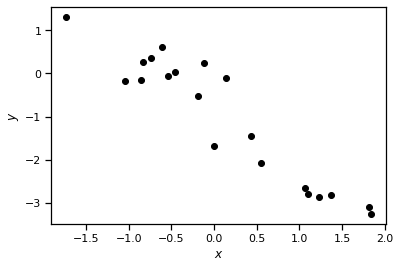

In [2]:
!wget -nc https://raw.githubusercontent.com/slinderman/stats305c/main/assignments/hw1/hw1.pt

# Load the data.
# X = [[1, x_1]
#      [1, x_2]
#         ...
#      [1, x_N]]
#
# y = [y_1, ..., y_N]
X, y = torch.load("hw1.pt")

plt.plot(X[:, 1], y, 'ko')
plt.xlabel("$x$")
plt.ylabel("$y$")

Here, the outcomes were simulated from a linear regression with Gaussian noise according to some true parameters (not given). You will compute and visualize the posterior distribution over the weights and variance given the data.

## Problem 3: Compute the posterior [Code]

Write a function to compute the posterior parameters given data and hyperparameters.

*Hints*: You may find the following commands in PyTorch useful:
- If ```a``` is a tensor, ```a.shape``` is a tuple containing the shape of ```a```.
- If ```a``` is a tensor, ```a.T``` returns the transpose of ```a```.
- ```torch.linalg.solve```
- ```*``` denotes element-wise multiplication while ```@``` denotes standard matrix-matrix or matrix-vector multiplication.

In [3]:
INV = torch.linalg.inv 
SOLVE = torch.linalg.solve

def compute_posterior(X, y, nu_0, sigmasq_0, mu_0, Lambda_0):
    """
    Compute the posterior parameters nu_N, sigmasq_N, mu_N, and Lambda_N 
    given covariates X, outcomes y, and hyperparameters.

    Args:
        X:          (N, D) tensor of covariates
        y:          (N,) tensor of outcomes
        nu_0:       prior degrees of freedom
        sigmasq_0:  prior mean of the variance parameter
        mu_0:       prior mean of the weights
        Lambda_0:   prior precision of the weights

    Returns:
        nu_N:       posterior degrees of freedom
        sigmasq_N:  posterior mean of the variance parameter
        mu_N:       posterior mean of the weights
        Lambda_N:   posterior precision of the weights
    """
    Lambda_N = torch.add(Lambda_0, X.T @ X)
    nu_N = nu_0 + torch.tensor(X.shape[0])
    mu_N = SOLVE(Lambda_N, Lambda_0 @ mu_0 + X.T @ y)
    sigmasq_N = (1 / nu_N) * (
        nu_0 * sigmasq_0 
        + mu_0.T @ Lambda_0 @ mu_0
        + y.T @ y 
        - mu_N.T @ Lambda_N @ mu_N
    )
    
    return (
        nu_N, 
        sigmasq_N, 
        mu_N, 
        Lambda_N
    )

Please run the following code to print your answers:

In [4]:
# Test:
hypers = dict(
    nu_0=torch.tensor(1.0),
    sigmasq_0=torch.tensor(1.0),
    mu_0=torch.zeros(2),
    Lambda_0=0.1 * torch.eye(2)
)

nu_N, sigmasq_N, mu_N, Lambda_N = compute_posterior(X, y, **hypers)
print("nu_N:       \n", nu_N)
print("")
print("sigmasq_N:  \n", sigmasq_N)
print("")
print("mu_N:       \n", mu_N)
print("")
print("Lambda_N:   \n", Lambda_N)

nu_N:       
 tensor(21.)

sigmasq_N:  
 tensor(0.2733)

mu_N:       
 tensor([-0.8777, -1.3646])

Lambda_N:   
 tensor([[20.1000,  2.4126],
        [ 2.4126, 20.0170]])


## Problem 4: Plot the posterior density of the variance [Code]

Plot $p(\sigma^2 \mid X, y, \eta)$ vs $\sigma^2$ over the interval $[10^{-3}, 2]$. 

You may use the `ScaledInvChiSq` distribution object below, which we copied from the demo for Lecture 1.

_Hint_: In Python, you can use `dir(object)` to list the attributes and functions that an object supports. 

_Hint_: To learn more about PyTorch distributions, see the [docs](https://pytorch.org/docs/stable/distributions.html).

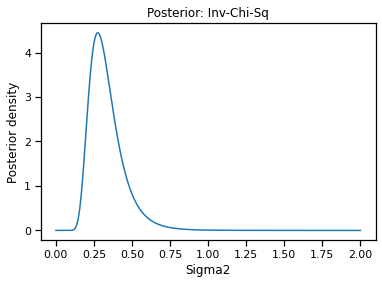

In [5]:
import numpy as np 

class ScaledInvChiSq(TransformedDistribution):
    
    def __init__(self, dof, scale):
        """
        Implementation of the scaled inverse \chi^2 distribution,
        
        ..math:
            \chi^{-2}(\nu_0, \sigma_0^2)

        It is equivalent to an inverse gamma distribution, which we implement
        as a transformation of a Gamma distribution. Thus, this class inherits
        functions like `log_prob` from its parent.

        Args:
            dof:   degrees of freedom parameter
            scale: mean of the $\chi^{-2}$ distribution.
        """
        base = Gamma(dof / 2, dof * scale / 2)
        transforms = [PowerTransform(-1)]
        TransformedDistribution.__init__(self, base, transforms)
        self.dof = dof
        self.scale = scale

posterior_invchisq = ScaledInvChiSq(nu_N, nu_N / (nu_N - 2) * sigmasq_N)
sigmasq = torch.linspace(1e-3, 2, 10000)      
plt.plot(
    sigmasq,
    torch.exp(posterior_invchisq.log_prob(sigmasq))
)
plt.xlabel("Sigma2")
plt.ylabel("Posterior density")
plt.title("Posterior: Inv-Chi-Sq")
plt.show()

## Problem 5: Plot posterior samples of the regression function. [Code]
Draw 50 samples from the posterior marginal distribution over the weights $\mathbf{w} \in \mathbb{R}^2$. For each sample, compute the expected value of $y$ on a grid of points $x$ evenly spaced between $[-3, 3]$. Remember that our covariates were defined as $\mathbf{x} = (1, x)$ so that for each sample of the weights you get a line for $\mathbb{E}[y \mid x, \mathbf{w}]$ as a function of $x$. Plot these 50 lines on top of each other to get a sense of the posterior uncertainty in the regression function. (You may want to plot each line with some transparency, like `alpha=0.1`.) Overlay the observed data points. 

*Hint*: You may find ```torch.inverse``` useful.

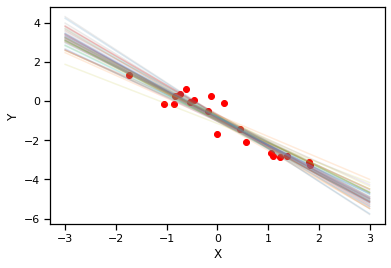

In [6]:
S = 50 # number of samples
xhat = torch.stack([ # features for prediction
  torch.ones(1000), 
  torch.linspace(-3, 3, 1000)
]).T

### two-step draw from NInvChiSq
sigma2_samples = posterior_invchisq.sample((S, )) # 
w_samples = MultivariateNormal(
    loc=mu_N[None, :], 
    covariance_matrix=torch.stack(
        [sig2 * INV(Lambda_N) for sig2 in sigma2_samples]
    )
).sample()

### predict
yhat = (xhat @ (w_samples.T))

for s in range(S):
  plt.plot(xhat[:, 1], yhat[:, s], alpha=.15)
plt.scatter(X[:, 1], y, color="red")
plt.ylabel("Y")
plt.xlabel("X")
plt.show()

## Bonus: Posterior Predictive Distribution [Math]
Derive the posterior predictive distribution of the outcome at a new input $\mathbf{x}_{N+1}$. That is, compute,
\begin{align}
p(y_{N+1} \mid x_{N+1}, \mathbf{y}, \mathbf{X}, \boldsymbol{\eta})
\end{align}
integrating over the posterior distribution on the weights $\mathbf{w}$ and variance $\sigma^2$.


---

First, recall the following, as set forth in Lecture 2 (pp. 17-18), we have that for 
$$
\mathbf{x}\sim N(\mathbf{b}, \mathbf{Q});\\
\mathbf{y}\sim N(\mathbf{C}\mathbf{x} + \mathbf{d}, R),
$$
we have by block matrix formulation and marginalization of an MVN that
$$
\mathbf{y}\sim N(\mathbf{C}\mathbf{b} + \mathbf{d}, CQC^T + R).
$$
Given that the posterior predictive situation is (reparameterizing to an inverse-gamma about $\alpha_N, \beta_N$ that correspond one-to-one with $\eta_N, \sigma^2_N$) 
\begin{align*}
\mathbf{w}, \sigma^2 \mid \mathbf{y}, \mathbf{X}, \boldsymbol{\eta}) 
&\sim
\chi^{-2}(\sigma^2 \mid \nu_N, \sigma_N^2)
 \mathcal{N}(\mathbf{w} \mid \boldsymbol{\mu}_N, \sigma^2 \boldsymbol{\Lambda}_N^{-1}) \\
&\sim 
\Gamma^{-1}(\sigma^2|\alpha_N, \beta_N)
 \mathcal{N}(\mathbf{w} \mid \boldsymbol{\mu}_N, \sigma^2 \boldsymbol{\Lambda}_N^{-1}),
\end{align*}
we have 
$$
\mathbf{w} 
\mid 
\langle 
\boldsymbol{\mu}_N, \sigma^2, \boldsymbol{\Lambda}_N^{-1}, \{\mathbf{X}, \mathbf{y}\}, \mathbf{\eta}, \ldots 
\rangle 
\sim 
\mathcal{N}(\boldsymbol{\mu}_N, \sigma^2 \boldsymbol{\Lambda}_N^{-1}); 
$$
$$
y_{N+1}| 
\langle 
X_{N+1},
\boldsymbol{\mu}_N, \sigma^2, \boldsymbol{\Lambda}_N^{-1}, \{\mathbf{X}, \mathbf{y}\}, \mathbf{\eta}, \ldots 
\rangle 
\sim \mathcal{N}(X_{N+1}\mathbf{w}, \sigma^2 I),
$$

---

so thus
$$
y_{N+1}| 
\langle 
X_{N+1},
\boldsymbol{\mu}_N, \sigma^2, \boldsymbol{\Lambda}_N^{-1}, \{\mathbf{X}, \mathbf{y}\}, \mathbf{\eta}, \ldots 
\rangle 
\sim \mathcal{N}(X_{N+1}\mathbf{w}, \sigma^2 (I_P + X_{N+1}\Lambda_N^{-1}X_{N+1}^T)).
$$
With this, we attempt to margin out $\sigma^2$. We have
\begin{align*}
p(y_{N+1}| 
\langle 
X_{N+1},
\boldsymbol{\mu}_N, \boldsymbol{\Lambda}_N^{-1}, \{\mathbf{X}, \mathbf{y}\}, \mathbf{\eta}, \ldots 
\rangle) 
&=
\int_{0}^{\infty}
p(y_{N+1}| 
\langle 
X_{N+1},
\boldsymbol{\mu}_N, \sigma^2, \boldsymbol{\Lambda}_N^{-1}, \{\mathbf{X}, \mathbf{y}\}, \mathbf{\eta}, \ldots 
\rangle) 
d\sigma^2\\
&=
\int_{0}^{\infty}
%%%% prior
\Gamma^{-1}(\sigma^2|\alpha_N, \beta_N)
%%%%% normal
\mathcal{N}(\mathbf{w} \mid \boldsymbol{\mu}_N, \sigma^2 \boldsymbol{\Lambda}_N^{-1})
\mathcal{N}y_{N+1} \mid X_{N+1}\mathbf{w}, \sigma^2I)
d\sigma^2\\
&=
\int_{0}^{\infty}
%%%% prior
\Gamma^{-1}(\sigma^2|\alpha_N, \beta_N)
%%%%% normal
\mathcal{N}\bigg(y_{N+1} \mid X_{N+1}\boldsymbol{\mu}_N, \sigma^2 (I + X_{N+1}\boldsymbol{\Lambda}_N^{-1}X_{N+1}^T)\bigg)
d\sigma^2\\
\end{align*}

At this point, it may be notationally advantageous to introduce some shorthands, namely
$$
\tilde \Sigma = I + X_{N+1}\Lambda_N^{-1}X_{N+1}^T
$$
and 
$$
\tilde \mu = X_{N+1}\mu_N.
$$
Hence, we continue with (where $\tilde N$ is the number of new predictions to be made)
\begin{align*}
&=
\int_{0}^{\infty}
%%%% prior
\Gamma^{-1}(\sigma^2|\alpha_N, \beta_N)
%%%%% normal
\mathcal{N}\bigg(y_{N+1} \mid X_{N+1}\boldsymbol{\mu}_N, \sigma^2 (I + X_{N+1}\boldsymbol{\Lambda}_N^{-1}X_{N+1}^T)\bigg)
d\sigma^2\\
&=
\int_{0}^{\infty}
%%%% prior
\Gamma^{-1}(\sigma^2|\alpha_N, \beta_N)
%%%%% normal
\mathcal{N}(y_{N+1} \mid \tilde \mu, \sigma^2 \tilde \Sigma)
d\sigma^2\\
&=
\int_{0}^{\infty}
\bigg[ 
\frac{\beta_N ^{\alpha_N}}{\Gamma(\alpha_N)}
(\sigma^2)^{-(\alpha_N + 1)} \exp\bigg(-\frac{\beta_N}{\sigma^2}\bigg)
\bigg]
\bigg[ 
\frac{1}{(2\pi\sigma^2)^{
\tilde N /2}|\tilde \Sigma|^{1/2}}
\exp\bigg(
-\frac{1}{2\sigma^2}(y_{N+1} - \tilde \mu)^T \tilde \Sigma^{-1} (y_{N+1} - \tilde \mu)
\bigg)
\bigg] d\sigma^2 \\
&=
\frac{\beta_N ^{\alpha_N}}{\Gamma(\alpha_N) (2\pi)^{
\tilde N /2}|\tilde \Sigma|^{1/2}}
\int_{0}^{\infty}
(\sigma^2)^{-(\alpha_N + 1 + \tilde N / 2)} \exp\bigg(-\frac{1}{\sigma^2}\bigg(\beta_N  
+\frac{1}{2}(y_{N+1} - \tilde \mu)^T \tilde \Sigma^{-1} (y_{N+1} - \tilde \mu)
\bigg) d\sigma^2 
\end{align*}

The term in the integral is quite clearly the integrated $\Gamma^{-1}$, where parameters are $\alpha = \tilde N / 2 + \alpha_N$ and $\beta =  \beta_N  
+\frac{1}{2}(y_{N+1} - \tilde \mu)^T \tilde \Sigma^{-1} (y_{N+1} - \tilde \mu)$. With appropriate scaling (which is missing here, as it is merely a kernel), it would integrate to 1; however, as it is missing the scaling constants, we know that it integrates to 
\begin{align}
\Lambda(\alpha)\beta^{-\alpha}
&=
\frac{
  \Gamma(\tilde N / 2 + \alpha_N)
}{
\bigg(
\beta_N  
+\frac{1}{2}(y_{N+1} - \tilde \mu)^T \tilde \Sigma^{-1} (y_{N+1} - \tilde \mu)
\bigg)^{\tilde N / 2 + \alpha_N}
}\\
&=
\Gamma(\tilde N / 2 + \alpha_N)
\bigg(
\beta_N  
+\frac{1}{2}(y_{N+1} - \tilde \mu)^T \tilde \Sigma^{-1} (y_{N+1} - \tilde \mu)
\bigg)^{-(\tilde N / 2 + \alpha_N)}
\end{align}

Thus, integrating out and adjusting for the normalizing constant, our expression is now
\begin{align*}
&=
\frac{\beta_N ^{\alpha_N}}{\Gamma(\alpha_N) (2\pi)^{
\tilde N /2}|\tilde \Sigma|^{1/2}}
\int_{0}^{\infty}
(\sigma^2)^{-(\alpha_N + 1 + \tilde N / 2)} \exp\bigg(-\frac{1}{\sigma^2}\bigg(\beta_N  
+\frac{1}{2}(y_{N+1} - \tilde \mu)^T \tilde \Sigma^{-1} (y_{N+1} - \tilde \mu)
\bigg) d\sigma^2 \\
&=
\frac{\beta_N ^{\alpha_N}}{\Gamma(\alpha_N) (2\pi)^{
\tilde N /2}|\tilde \Sigma|^{1/2}}\cdot 
\Gamma(\tilde N / 2 + \alpha_N)
\bigg(
\beta_N  
+\frac{1}{2}(y_{N+1} - \tilde \mu)^T \tilde \Sigma^{-1} (y_{N+1} - \tilde \mu)
\bigg)^{-(\tilde N / 2 + \alpha_N)}\\
&=
\frac{\beta_N ^{\alpha_N}}{\Gamma(\alpha_N) (2\pi)^{
\tilde N /2}|\tilde \Sigma|^{1/2}}\cdot 
\Gamma(\tilde N / 2 + \alpha_N)
\bigg(
\beta_N \bigg[1 
+\frac{1}{2}(y_{N+1} - \tilde \mu)^T (\beta_N \tilde \Sigma)^{-1} (y_{N+1} - \tilde \mu)\bigg]
\bigg)^{-(\tilde N / 2 + \alpha_N)}\\
&=
\frac{\beta_N ^{\alpha_N}}{\Gamma(\alpha_N) (2\pi)^{
\tilde N /2}|\tilde \Sigma|^{1/2}}\cdot 
\Gamma(\tilde N / 2 + \alpha_N)
\bigg(
\beta_N \bigg[1 
+\frac{\alpha_N}{2\alpha_N}(y_{N+1} - \tilde \mu)^T(\beta_N \tilde \Sigma)^{-1} (y_{N+1} - \tilde \mu)\bigg]
\bigg)^{-(\tilde N / 2 + \alpha_N)}\\
&=
\frac{\beta_N ^{\alpha_N}}{\Gamma(\alpha_N) (2\pi)^{
\tilde N /2}|\tilde \Sigma|^{1/2}}\cdot 
\Gamma(\tilde N / 2 + \alpha_N)
\bigg(
\beta_N \bigg[1 
+\frac{1}{2\alpha_N}(y_{N+1} - \tilde \mu)^T  \bigg(\frac{\beta_N}{\alpha_N}\tilde \Sigma\bigg)^{-1} (y_{N+1} - \tilde \mu)\bigg]
\bigg)^{-(\tilde N / 2 + \alpha_N)} \\
&=
\frac{\beta_N ^{-\tilde N / 2}}{\Gamma(\alpha_N) (2\pi)^{
\tilde N /2}|\tilde \Sigma|^{1/2}}\cdot 
\Gamma(\tilde N / 2 + \alpha_N)
\bigg(1 
+\frac{1}{2\alpha_N}(y_{N+1} - \tilde \mu)^T  \bigg(\frac{\beta_N}{\alpha_N}\tilde \Sigma\bigg)^{-1} (y_{N+1} - \tilde \mu)
\bigg)^{-(\tilde N / 2 + \alpha_N)}\\
&=
\frac{\Gamma((\tilde N + 2\alpha_N)/ 2 )}{\Gamma(\alpha_N) (2\pi)^{
\tilde N /2}|\beta_N \tilde \Sigma|^{1/2}}\cdot 
\bigg(1 
+\frac{1}{2\alpha_N}(y_{N+1} - \tilde \mu)^T  \bigg(\frac{\beta_N}{\alpha_N}\tilde \Sigma\bigg)^{-1} (y_{N+1} - \tilde \mu)
\bigg)^{-(\tilde N + 2\alpha_N)/ 2} \\
&\sim 
MVT\bigg(df = 2 \alpha_N; \mu = \tilde \mu; cov=\frac{\beta_N}{\alpha_N}\tilde \Sigma\bigg),
\end{align*}
where from above
$$
\tilde \Sigma = I + X_{N+1}\Lambda_N^{-1}X_{N+1}^T
$$
and 
$$
\tilde \mu = X_{N+1}\mu_N.
$$
Further, $\alpha_N, \beta_N$ represent the one-to-one $\chi^{-2}\to \Gamma^{-1}$ reparameterization, i.e. 
$$
\chi^{-2}(\sigma^2|\nu_N, \sigma^2_N) \iff 
\Gamma^{-1}(\sigma^2 | \frac{\nu_N}{2}, \frac{\nu_N\sigma_N^2}{2}),
$$
hence $\alpha_N = \frac{\nu_N}{2}; \beta_N = \frac{\nu_N\sigma_N^2}{2}$.


Steps are justified by: (i) substitution of the normalizing constant above; (ii) factoring of $\beta_N$; (iii) insertion of a $1 = \alpha_N / \alpha_N$; (iv) rearrangement; (v) moving $\beta_N$ leftwards and cancellation; (vi) insertion of $\beta_N$ back into the determinant, where it appears $\tilde N$ times. 

# Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. You can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF.  Then run the following command to convert to a PDF:
```
jupyter nbconvert --to pdf <yourname>_hw1.ipynb
```


**Installing nbconvert:**

If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

**Upload** your .ipynb and .pdf files to Gradescope. 